# Classification avec Transformer (Encoder seul)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

## Chargement et prétraitement des données (seulement en anglais)

In [26]:
toots = pd.read_csv('../data/100k_en_toots_labeled.csv').dropna()
print('Taille de base:', len(toots))

# toots en anglais
itoots_en = toots['language'] == 'en'
toots_en = toots[itoots_en]
toots_en = toots_en[['content', 'y']]

nb_neg = (toots_en['y'] == 0).sum()
nb_pos = (toots_en['y'] == 1).sum()

print('Taille des toots en anglais', len(toots_en))
print(f'Nb pos {nb_pos} Nb neg {nb_neg}  total: {nb_pos+nb_neg}')
toots_en.head()

Taille de base: 93273
Taille des toots en anglais 47465
Nb pos 1011 Nb neg 46454  total: 47465


,content,y
0,Chikmagalur Tourist Places: Your Ultimate Guid...,0
1,"Dancing Adélie Penguins, McMurdo Sound, Antar...",0
2,2 Macdonald trip leaving Burrard Station @ Bay...,0
3,"Here you go seekers, some more good music (the...",0
11,The Future of Nuclear Energy in a Carbon-Const...,0


In [47]:
# tokenisation
ltoots_en = [(word_tokenize(toots_en.iloc[i]['content'].lower()), toots_en.iloc[i]['y']) for i in range(len(toots_en))]

# suppression des stops words
stop_words = set(stopwords.words("english"))
mots = [([token for token in ltokens if token not in stop_words], y) for ltokens,y in ltoots_en]

# Lemmatisation
lemmatiseur = WordNetLemmatizer()
ltoots_en = [([lemmatiseur.lemmatize(token) for token in ltokens], int(y)) for ltokens,y in ltoots_en]

In [49]:
# ltoots_en[0]

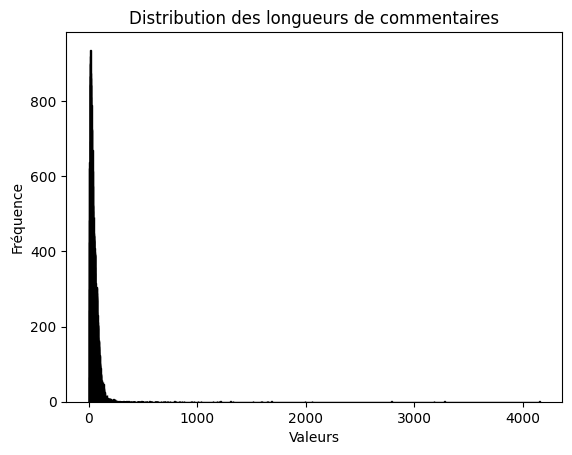

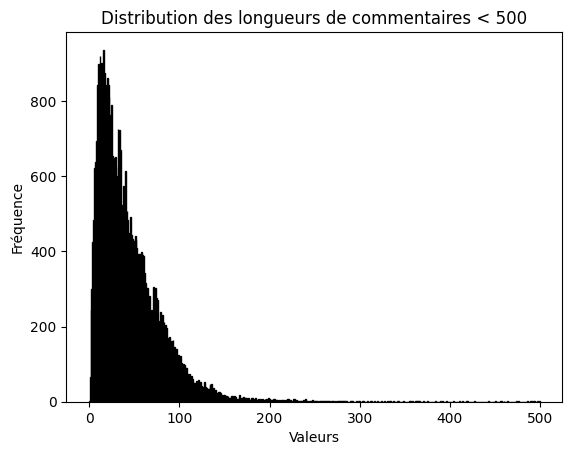

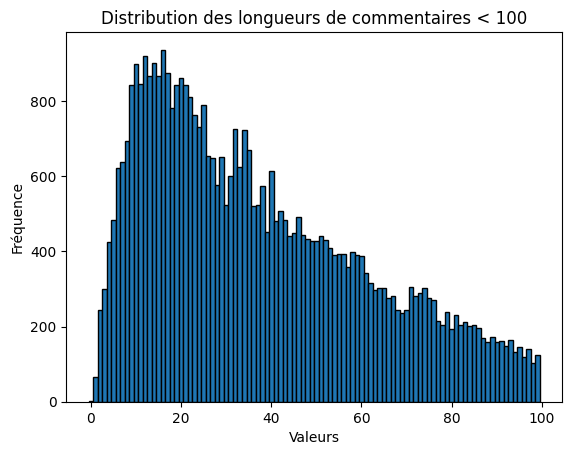

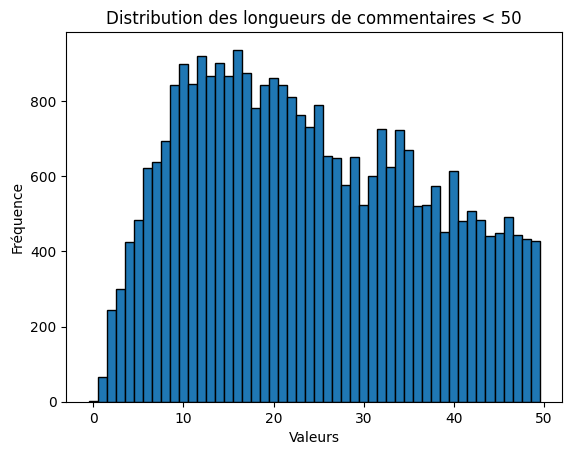

In [64]:

import matplotlib.pyplot as plt
import numpy as np

len_coms = [len(lt) for lt,y in ltoots_en]

plt.hist(len_coms, bins=np.arange(min(len_coms), max(len_coms) + 1.5) - 0.5, edgecolor='black')
plt.title('Distribution des longueurs de commentaires')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

# longueur commentaires inferieur à k
k = 500
len_coms = [len(lt) for lt,y in ltoots_en if len(lt)<k]

plt.hist(len_coms, bins=np.arange(min(len_coms), max(len_coms) + 1.5) - 0.5, edgecolor='black')
plt.title(f'Distribution des longueurs de commentaires < {k}')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

# longueur commentaires inferieur à k
k = 100
len_coms = [len(lt) for lt,y in ltoots_en if len(lt)<k]

plt.hist(len_coms, bins=np.arange(min(len_coms), max(len_coms) + 1.5) - 0.5, edgecolor='black')
plt.title(f'Distribution des longueurs de commentaires < {k}')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

# longueur commentaires inferieur à k
k = 50
len_coms = [len(lt) for lt,y in ltoots_en if len(lt)<k]

plt.hist(len_coms, bins=np.arange(min(len_coms), max(len_coms) + 1.5) - 0.5, edgecolor='black')
plt.title(f'Distribution des longueurs de commentaires < {k}')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

In [52]:
words = []
[[words.append(word) for word in ltokens] for ltokens, y in ltoots_en]
words = set(words)
words = list(words) # list des mots sans duplication

OOVID = len(words)
words.append('__OOV__')
word2id = {word: ix for ix, word in enumerate(words)}

In [54]:
toots_en_ix = [([word2id[word] for word in ltokens], y) for ltokens,y in ltoots_en]

In [1]:
nb_words = len(words)
toots_vect = []

for litokens, y in toots_en_ix:
  lvects = []
  for itoken in litokens:
    vect = np.zeros(nb_words)
    vect[itoken] = 1
    lvects.append(vect)
  toots_vect.append((lvects,y))

NameError: name 'words' is not defined

In [78]:
toots_vect[0][0][4].shape

(119709,)

Maintenant chaque toot, qui etait au debut une phrase, est une liste de vecteurs. Où chaque vecteur contient que des zeros sauf à la position id du mot. La position id est donnée par le dictionnaire word2id. (word to vect)

## On limite les sequences à 100 et on pad les sequences de taille inferieur à 100 pour obtenir des sequences de meme taille

In [79]:
MAX_LENGTH = 100
PAD = word2id["__OOV__"]


data = [torch.LongTensor(lvects[:MAX_LENGTH]) for lvects,y in toots_vect]
lens = [len(d) for d in data]
data2 = torch.nn.utils.rnn.pad_sequence(data, batch_first=True,padding_value = PAD)
lens2 = [len(d) for d in data]

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_20492/1999409364.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  data = [torch.LongTensor(lvects[:MAX_LENGTH]) for lvects,y in toots_vect]


KeyboardInterrupt: 

In [ ]:
np.unique(lens2), np.unique(lens)

## DataLoader

In [22]:
class MonDataLoader(Dataset):
  def __init__(self, data, lookback_size, lookforward_size):
    self.lookback_size = lookback_size
    self.lookforward_size = lookforward_size
    self.data = []
    for i in range(0, 1 + len(data) - (self.lookback_size+ self.lookforward_size), self.lookback_size):
      seq_x = data[i:i+self.lookback_size, :]
      seq_y = data[i+self.lookback_size:i+self.lookback_size+self.lookforward_size, :]
      self.data.append((seq_x, seq_y))

  def __len__(self):
    return len(self.data) - 1

  def __getitem__(self, idx):
    seq_x, seq_y = self.data[idx]
    return torch.tensor(seq_x), torch.tensor(seq_y)

#### dataloader

In [30]:
batch_size = 32
input_len = 96
pred_len = 96

train_dataset = MonDataLoader(train_data, input_len, pred_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_dataset = MonDataLoader(val_data, input_len, pred_len)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MonDataLoader(test_data, input_len, pred_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Transformer

In [8]:
class SAttention(nn.Module):
  def __init__(self, k, heads, mask=False):
    """

    :param k: taille de l'embeding
    :param heads: nombre de heads
    :param mask: attention sur toute la seq(False) ou les elts precs seulement
    """
    
    super(SAttention, self).__init__()
    
    assert k % heads == 0, f'heads ({heads}) doit etre un diviseur de k ({k})'

    self.k = k
    self.heads = heads
    self.mask = mask
    
    self.tokeys = nn.Linear(k, k, bias=False)
    self.toqueries = nn.Linear(k, k, bias=False)
    self.tovalues = nn.Linear(k, k, bias=False)

    self.unifyHeads = nn.Linear(k,k)
  
  def forward(self, x):
    
    b, t, k = x.size()
    h = self.heads
    assert k == self.k, f'Taille des embeddings ({k}) doit correspond a celui du init ({self.k})'

    keys = self.tokeys(x)
    queries = self.toqueries(x)
    values = self.tovalues(x)
    
    # Taille de chaque head
    s = k // h
    
    # batch x longueur seq x nb heads x taille head
    keys = keys.view(b, t, h, s)
    queries = queries.view(b, t, h, s)
    values = values.view(b, t, h, s)
    
    # batch et head cote à cote
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
    values = values.transpose(1, 2).contiguous().view(b * h, t, s)

    dot = torch.bmm(queries, keys.transpose(1, 2)) # -> (b*h, t, t)
    dot = dot / (k ** (1/2))
    
    if self.mask:
      indices = torch.triu_indices(t, t, offset=1)
      dot[:, indices[0], indices[1]] = float('-inf')

    dot = F.softmax(dot, dim=2)
    
    out = torch.bmm(dot, values).view(b, h, t, s)

    # rearrangement
    out = out.transpose(1, 2).contiguous().view(b, t, h*s)

    # unification avec MLP
    out = self.unifyHeads(out) # -> (b, t, k)

    return out


In [ ]:
"""
def forward_einsum(self, x):
    b, t, e = x.size()
    h = self.heads

    keys    = self.tokeys(x).view(b, t, h, e)
    queries = self.toqueries(x).view(b, t, h, e)
    values  = self.tovalues(x).view(b, t, h, e)

    dot = torch.einsum('bthe,bihe->bhti', queries, keys) / math.sqrt(e)
    dot = F.softmax(dot, dim=-1)

    out = torch.einsum('bhtd,bdhe->bthe', dot, values)

    # we can move reshape of weights to init; I left it here just to compare with the original implementation
    out = torch.einsum('bthe,khe->btk', out, self.unifyheads.weight.view(e,h,e)) 
    return out + self.unifyheads.bias
"""

In [9]:
class TBlock(nn.Module):
  def __init__(self, k, heads):
    super(TBlock, self).__init__()
    
    self.attention = SAttention(k, heads)
    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.feedforward = nn.Sequential(
      nn.Linear(k, 4*k),
      nn.ReLU(),
      nn.Linear(4*k, k)
    )
  
  def forward(self, x):
    attention = self.attention(x)
    x = x + attention
    x = self.norm1(x)
    
    feedforward = self.feedforward(x)
    x = x + feedforward
    out = self.norm2(x)

    return out

In [10]:
class iTransformer(nn.Module):
  def __init__(self, input_len, pred_len, N, D, heads=4, L=6, name=None):
    super(iTransformer, self).__init__()
    
    self.T = input_len  # lookback input size
    self.S = pred_len   # lookforward size, prediction size
    self.N = N          # nb series multivariees
    self.D = D          # dim embeddings
    self.heads = heads  # nb attention heads
    self.L = L          # nb TBlocks
    self.name = name
    
    self.toEmbs = nn.Sequential(
      nn.Linear(self.T, 4 * self.T),
      nn.ReLU(),
      nn.Linear(4 * self.T, self.D)
    ) # N x T -> N x D
    # print(f'embs params \n{self.toEmbs.parameters}')

    tblocks = [TBlock(k=self.D, heads=heads) for _ in range(L)] # heads diviseur de D
    self.tblocks = nn.Sequential(*tblocks) # N x D -> N x D
    
    # projection
    self.projection = nn.Sequential(
      nn.Linear(self.D, 4 * self.D),
      nn.ReLU(),
      nn.Linear(4 * self.D, 8 * self.D),
      nn.ReLU(),
      nn.Linear(8 * self.D, 16 * self.D),
      nn.ReLU(),
      nn.Linear(16 * self.D, self.S)
    ) # N x D -> N x S (transpose) -> S x N
    
    # print('Constructeur de iTransformer')
    # print(f'lb {self.T} lf {self.S} mvs {N}')
  
  def forward(self, x):
    """

    Args:
      x (b, lookbacksize, N): entree batch de sequences multi variees
    """
    # print('Forward iTransformer')
    # print(f'size batch avant transpose {x.size()}')
    x = x.transpose(1, 2).contiguous()  # inverted transformer (b, T, N) -> (b, N, T)
    b, N, T = x.size()
    # print(f'size batch après transpose {x.size()}')

    assert T == self.T, f'Taille de la sequence ({T}) doit correspondre a la lookback input size({self.T})'
    assert N == self.N, f'Nombre de mvs ({N}) doit correspondre à N({self.N})'
    

    H0 = self.toEmbs(x)   # (b, N, T) -> (b, N, D)
    # print(f'H0 embed size {H0.size()}')

    HL = self.tblocks(H0) # (b, N, D) -> (b, N, D)
    # print(f'HL embed size {HL.size()}')

    # prediction
    out = self.projection(HL)          # (b, N, D) -> (b, N, S)
    # print(f'projection size {out.size()} -- b {b} N {N} D {self.D} S {self.S}')
    out = out.transpose(1, 2).contiguous() # (b, N, S) -> (b, S, N)
    # print(f'transpose projection size {out.size()} -- b {b} N {N} D {self.D} S {self.S}')
    
    return out
    

## ECL


In [24]:
lr = 3e-4
num_epochs = 10

ecl_iTransformer = iTransformer(input_len=input_len, pred_len=pred_len, N=321, D=256, heads=4, L=3, name='ECL iTransformer')

criterion = nn.MSELoss()
optimizer = optim.Adam(ecl_iTransformer.parameters(), lr=lr)

tloss, eloss, teloss = [], [], []

In [26]:


for epoch in range(num_epochs):
  print(f"Epoch [{(epoch+1):4d}/{num_epochs:4d}] ")
  lep = []
  ecl_iTransformer.train()
  for batch_idx, (seq_x, seq_y) in enumerate(train_loader):
    seq_pred = ecl_iTransformer(seq_x)
    
    loss = criterion(seq_pred, seq_y)
    
    ecl_iTransformer.zero_grad()
    loss.backward()
    optimizer.step()

    # save loss
    lep.append(loss.detach().numpy())
    
    print(
      f"\ttrain batch [{(batch_idx+1):4d}/{len(train_loader):4d}] \ "
      f"Loss : {loss:.4f}", end="\r"
    )
  print(
    f"\ttrain batch [{(batch_idx+1):4d}/{len(train_loader):4d}] \ "
    f"Loss : {loss:.4f}"
  )
  tloss.append(np.mean(lep))
  
  ecl_iTransformer.eval()
  lep = []
  for batch_idx, (seq_x, seq_y) in enumerate(eval_loader):
    seq_pred = ecl_iTransformer(seq_x)
    loss = criterion(seq_pred, seq_y)
    lep.append(loss.detach().numpy())
    
    print(
      f"\teval  batch [{(batch_idx+1):4d}/{len(eval_loader):4d}] \ "
      f"Loss : {loss:.4f}", end="\r"
    )
  print(
    f"\teval  batch [{(batch_idx+1):4d}/{len(eval_loader):4d}] \ "
    f"Loss : {loss:.4f}"
  )
  eloss.append(np.mean(lep))
  

Epoch [   1/  10] 


/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_6293/577648859.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(seq_x), torch.tensor(seq_y)


	train batch [   6/   6] \ Loss : 0.1861
	eval  batch [   1/   1] \ Loss : 0.4109
Epoch [   2/  10] 
	train batch [   6/   6] \ Loss : 0.1689
	eval  batch [   1/   1] \ Loss : 0.4058
Epoch [   3/  10] 
	train batch [   6/   6] \ Loss : 0.1721
	eval  batch [   1/   1] \ Loss : 0.4016
Epoch [   4/  10] 
	train batch [   6/   6] \ Loss : 0.1695
	eval  batch [   1/   1] \ Loss : 0.3868
Epoch [   5/  10] 
	train batch [   6/   6] \ Loss : 0.1810
	eval  batch [   1/   1] \ Loss : 0.4189
Epoch [   6/  10] 
	train batch [   6/   6] \ Loss : 0.1582
	eval  batch [   1/   1] \ Loss : 0.3509
Epoch [   7/  10] 
	train batch [   6/   6] \ Loss : 0.1710
	eval  batch [   1/   1] \ Loss : 0.3784
Epoch [   8/  10] 
	train batch [   6/   6] \ Loss : 0.2000
	eval  batch [   1/   1] \ Loss : 0.3408
Epoch [   9/  10] 
	train batch [   6/   6] \ Loss : 0.1674
	eval  batch [   1/   1] \ Loss : 0.3372
Epoch [  10/  10] 
	train batch [   6/   6] \ Loss : 0.1685
	eval  batch [   1/   1] \ Loss : 0.3734


In [52]:
teloss, lseq_pred = [], []

ecl_iTransformer.eval()
with torch.no_grad():
  for batch_idx, (seq_x, seq_y) in enumerate(test_loader):
    seq_pred = ecl_iTransformer(seq_x)
    loss = criterion(seq_pred, seq_y)
    teloss.append(loss.detach().numpy())
    lseq_pred.append((seq_y, seq_pred))


print(f'Mean loss in test: {(np.mean(teloss)):.4f}')

/var/folders/x7/bmqxr1zd3lxd_kcxxw9physr0000gn/T/ipykernel_6293/577648859.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(seq_x), torch.tensor(seq_y)


Mean loss in test: 0.2707


In [27]:
torch.save(ecl_iTransformer.state_dict(), './models/ecl_iTransformer')

[0.679637, 0.3858271, 0.32096127, 0.27665457, 0.2527983, 0.23711266, 0.22748704, 0.21701406, 0.2090006, 0.20743906, 0.20188265, 0.19457684, 0.19215597, 0.18638702, 0.18297297, 0.17991091, 0.18268454, 0.17812777, 0.1790465, 0.17283744] 
 [0.8446521, 0.7450773, 0.63740015, 0.53813577, 0.52533823, 0.5109519, 0.43708122, 0.44519147, 0.4300331, 0.48002437, 0.4108916, 0.40581185, 0.40156162, 0.3867513, 0.41887507, 0.35090685, 0.3784059, 0.3407729, 0.3372201, 0.37344384]


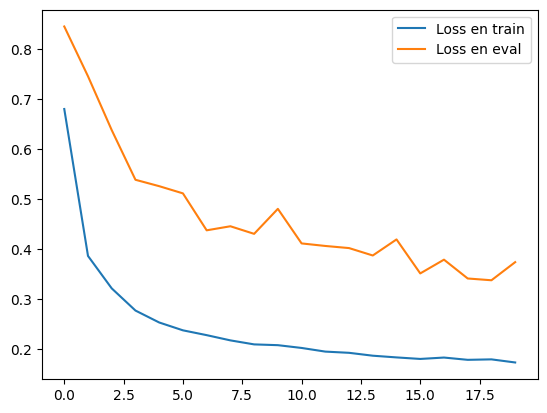

In [28]:
import matplotlib.pyplot as plt

print(tloss, '\n',eloss)
plt.figure()
plt.plot(tloss,label="Loss en train")
plt.plot(eloss,label="Loss en eval")
plt.legend()
plt.show()

## Test sur une seule serie

In [53]:
ibatch, iseq = 0, 0
bseq_y, bseq_pred = lseq_pred[ibatch]
seq_y, seq_pred = bseq_y[iseq], bseq_pred[iseq]

seq_y.size(), seq_pred.size(), type(seq_y), type(seq_pred)

(torch.Size([96, 321]), torch.Size([96, 321]), torch.Tensor, torch.Tensor)

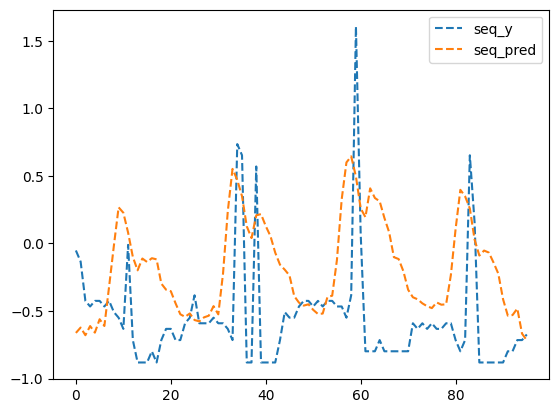

In [58]:
i = 0

plt.figure()
plt.plot(seq_y[:, i],    "--", label="seq_y")
plt.plot(seq_pred[:, i], "--", label="seq_pred")
plt.legend()
plt.show()

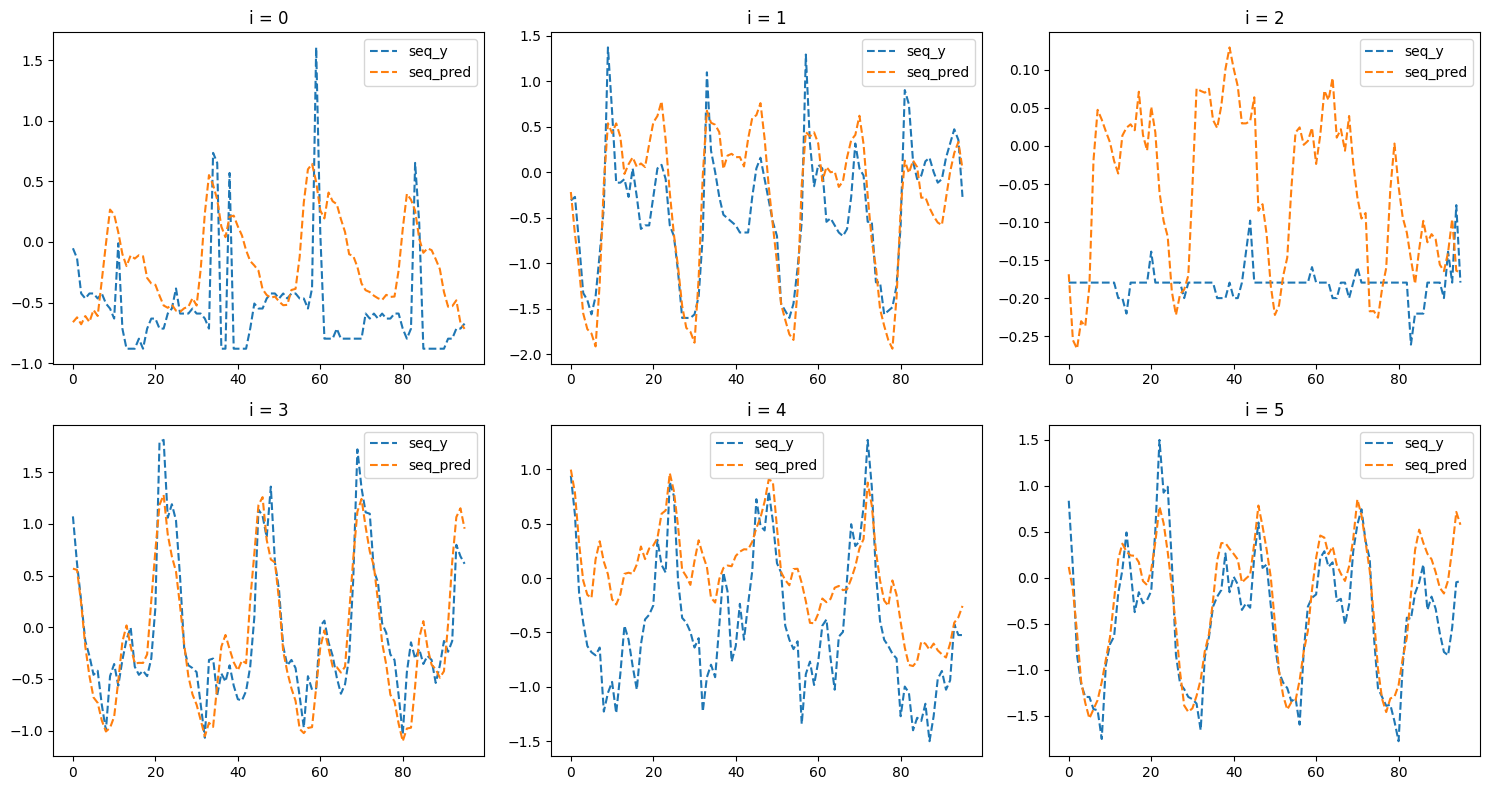

In [59]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    current_i = i - 1
    
    plt.plot(seq_y[:,    current_i], "--", label="seq_y")
    plt.plot(seq_pred[:, current_i], "--", label="seq_pred")
    
    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

## Test sur un temps t

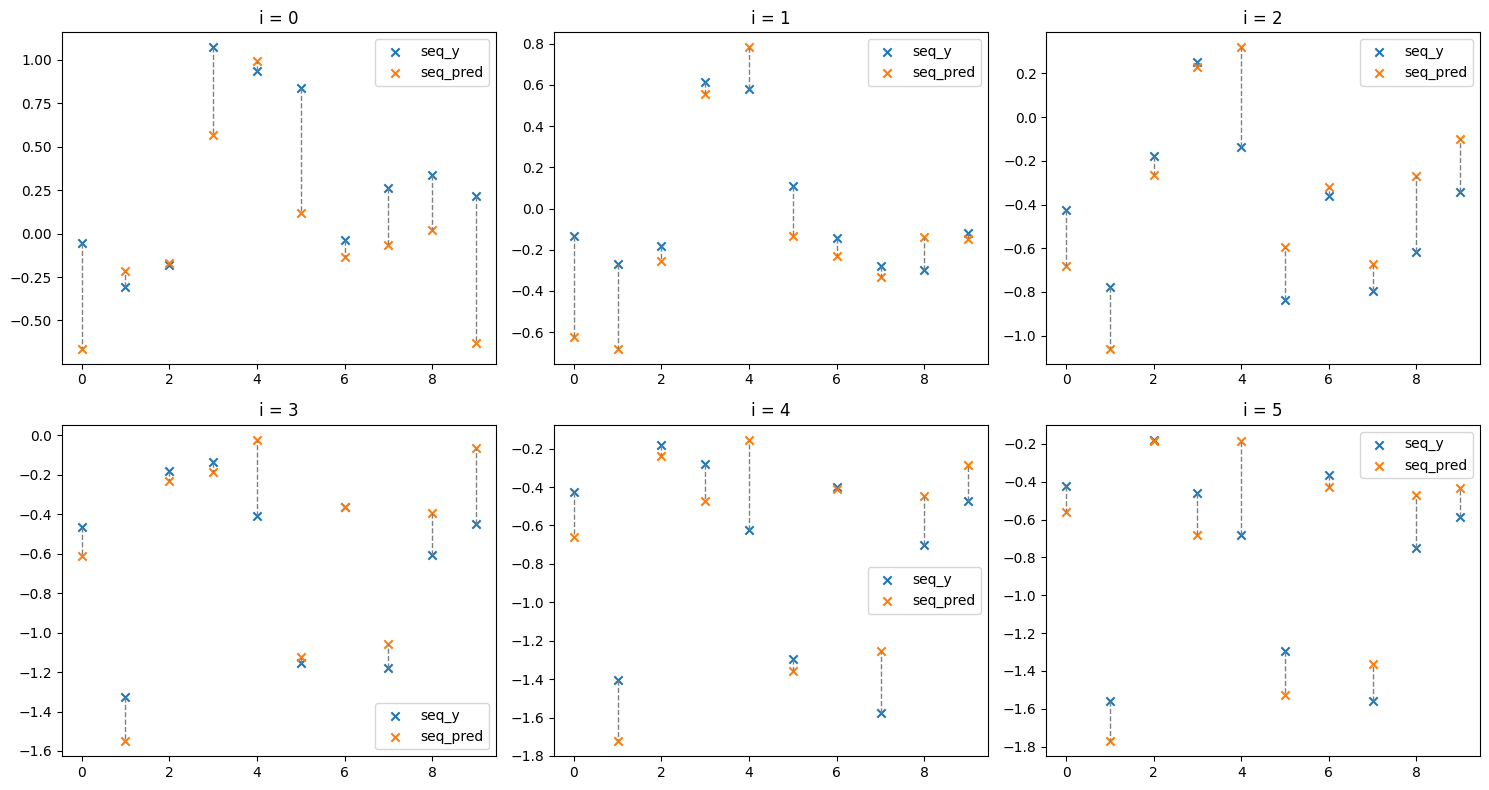

In [62]:
plt.figure(figsize=(15, 8))
k = 10

for i in range(1, 7):
    plt.subplot(2, 3, i)
    
    current_i = i - 1
    
    plt.scatter(np.arange(k), seq_y   [current_i, :k], marker='x', label="seq_y")
    plt.scatter(np.arange(k), seq_pred[current_i, :k], marker='x', label="seq_pred")

    for j in range(k):
        plt.plot([j, j], [seq_y[current_i, j], seq_pred[current_i, j]], color='gray', linestyle='--', linewidth=1)

    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()